In [1]:
import numpy as np
import theano.tensor as T
from lasagne.layers import *
from lasagne.nonlinearities import *
from lasagne.objectives import *
from lasagne.updates import *

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from visualize import draw_to_file
from IPython.display import Image

In [3]:
import load_mnist

In [5]:
mc = np.load("./mnist_sequence1_sample_5distortions5x5.npz")
#X_train, y_train, X_valid, y_valid, _, _ = load_mnist.load_dataset()
X_train, y_train, X_valid, y_valid = mc['X_train'], mc['y_train'], mc['X_valid'], mc['y_valid']
X_train = X_train.reshape((-1, 1, 40, 40))
X_valid = X_valid.reshape((-1, 1, 40, 40))
y_train = y_train.flatten()
y_valid = y_valid.flatten()

----------

In [6]:
def get_layer_with_tag(l_out, tag):
    for layer in get_all_layers(l_out):
        if hasattr(layer, 'tag') and layer.tag==tag:
            return layer
    return None

In [143]:
def get_net():
    l_in = InputLayer((None, 1, 40, 40))
    conv = l_in
    conv = batch_norm(Conv2DLayer(conv, num_filters=32, filter_size=3, stride=2))
    conv = batch_norm(Conv2DLayer(conv, num_filters=48, filter_size=3, stride=1))
    conv = batch_norm(Conv2DLayer(conv, num_filters=64, filter_size=3, stride=2))
    conv = batch_norm(Conv2DLayer(conv, num_filters=96, filter_size=3, stride=1))
    conv.tag = "fm"
    conv = DenseLayer(conv, num_units=10, nonlinearity=linear)
    conv = NonlinearityLayer(conv, nonlinearity=softmax)
    conv.tag = "dense"
    return conv
    
    #return {'in':l_in, 'out':out, 'code':code, 'eps':l_eps}

In [144]:
l_out = get_net()
for layer in get_all_layers(l_out):
    print layer, layer.output_shape
count_params(l_out)

<lasagne.layers.input.InputLayer object at 0x11eec56d0> (None, 1, 40, 40)
<lasagne.layers.conv.Conv2DLayer object at 0x11eee5310> (None, 32, 19, 19)
<lasagne.layers.normalization.BatchNormLayer object at 0x11d3fe0d0> (None, 32, 19, 19)
<lasagne.layers.special.NonlinearityLayer object at 0x12685ba50> (None, 32, 19, 19)
<lasagne.layers.conv.Conv2DLayer object at 0x12685bc50> (None, 48, 17, 17)
<lasagne.layers.normalization.BatchNormLayer object at 0x12685bd90> (None, 48, 17, 17)
<lasagne.layers.special.NonlinearityLayer object at 0x12685bcd0> (None, 48, 17, 17)
<lasagne.layers.conv.Conv2DLayer object at 0x12685bf50> (None, 64, 8, 8)
<lasagne.layers.normalization.BatchNormLayer object at 0x12685bd10> (None, 64, 8, 8)
<lasagne.layers.special.NonlinearityLayer object at 0x12685b9d0> (None, 64, 8, 8)
<lasagne.layers.conv.Conv2DLayer object at 0x12646f7d0> (None, 96, 6, 6)
<lasagne.layers.normalization.BatchNormLayer object at 0x12646fbd0> (None, 96, 6, 6)
<lasagne.layers.special.Nonlinearity

132586

---------

In [145]:
x = T.tensor4('x')
y = T.ivector('y')
net_out = get_output(l_out, x)

In [146]:
loss = categorical_crossentropy(net_out, y).mean()

In [147]:
params = get_all_params(l_out, trainable=True)

In [148]:
updates = adam(loss, params)

-------

In [149]:
def iterator(xx, yy, bs, shuffle=True):
    if shuffle:
        idxs = np.arange(0, xx.shape[0])
        np.random.shuffle(idxs)
        xx, yy = xx[idxs], yy[idxs]
    for b in range( (xx.shape[0] // bs) + 1 ):
        if xx[b*bs:(b+1)*bs].shape[0]==0:
            break
        yield xx[b*bs:(b+1)*bs], yy[b*bs:(b+1)*bs]

In [150]:
train_fn = theano.function([x,y], loss, updates=updates, on_unused_input='warn')

In [154]:
net_out_det, net_out_before_det, fm_out_det = get_output(
    [l_out, l_out.input_layer, get_layer_with_tag(l_out, 'fm')],
    x, deterministic=True)
out_fn = theano.function([x], net_out_det)
fn_fm = theano.function([x], fm_out_det)

In [155]:
jacob_fn = theano.function([x], T.jacobian(net_out_before_det.flatten(), fm_out_det))

In [239]:
for epoch in range(0,100):
    losses = []
    for x_batch, y_batch in iterator(X_train, y_train, 32):
        aa = train_fn(x_batch, y_batch)
        losses.append(aa)
    print epoch+1, np.mean(losses)

1 0.0422354503252
2 0.0254550033732
3 0.0245818969669
4 0.0449789881974
5 0.0331513285199


KeyboardInterrupt: 

In [133]:
import cPickle as pickle
with open("wts_gradcam.pkl", "wb") as f:
    pickle.dump(get_all_param_values(l_out), f)

---------

In [240]:
preds = []
for x_batch, y_batch in iterator(X_valid, y_valid, 32, shuffle=False):
    preds += np.argmax(out_fn(x_batch),axis=1).tolist()
print (preds==y_valid).mean()

0.959


In [34]:
from skimage.transform import resize

In [264]:
jacob_fn(x_batch[0:1]).shape

(10, 1, 96, 6, 6)

In [254]:
def plot_fm_for_class(inp, resize_to, num_classes=10, figsize=(10,10), plot=True):
    assert inp.shape[0] == 1
    this_fms = fn_fm(inp)[0]
    jacobs = jacob_fn(inp)
    if plot:
        plt.figure(figsize=figsize)
        plt.subplot(1, num_classes+1, 1)
        plt.imshow(inp[0][0])
        plt.axis('off')
    fms = []
    print "predicted class:", np.argmax(out_fn(inp),axis=1)
    for k in range(num_classes):
        # create the weighted feature map for class k
        result = np.zeros_like(this_fms[0])
        for i in range(this_fms.shape[0]):
            # multiply the i'th feature map by the i'th weight for class k
            this_wt = np.mean(jacobs[k][0][i])
            this_fm_weighted = this_fms[i]*this_wt
            result += this_fm_weighted
        # then apply relu
        result[ result < 0 ] = 0.
        #print np.sum(np.isnan(jacobs))
        #print np.min(result), np.max(result)
        result = (result - np.max(result)) / (np.max(result) - np.min(result) + 1e-6)
        this_fm_resized = resize(result, output_shape=resize_to)
        #if debug:
        #    print "magnitute for class %i = %f" % (k, np.sum(this_fm_resized))
        #this_fm_resized = (this_fm_resized - np.min(this_fm_resized)) / (np.max(this_fm_resized)-np.min(this_fm_resized))
        if plot:
            plt.subplot(1, num_classes+1, k+2)
            plt.imshow(this_fm_resized)
            plt.title(str(k))
            plt.axis('off')
        fms.append(this_fm_resized)
    if not plot:
        return fms

In [242]:
x_batch = X_train[0:32]

predicted class: [3]


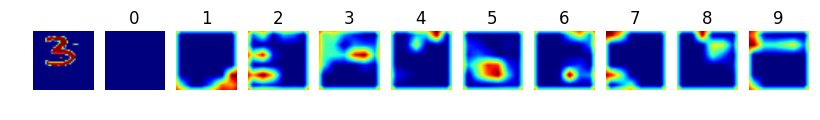

In [255]:
plot_fm_for_class(x_batch[11:12], resize_to=(40,40) )

predicted class: [0]


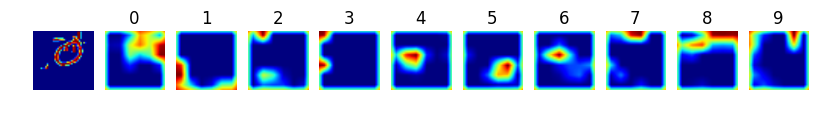

In [256]:
plot_fm_for_class(x_batch[2:3], resize_to=(40,40) )

predicted class: [7]


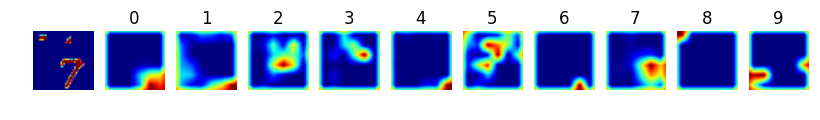

In [257]:
plot_fm_for_class(X_train[101:102], resize_to=(40,40) )

predicted class: [7]


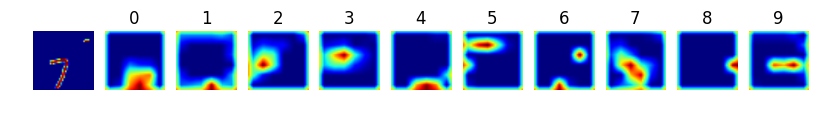

In [258]:
plot_fm_for_class(X_train[9:10], resize_to=(40,40) )

predicted class: [5]


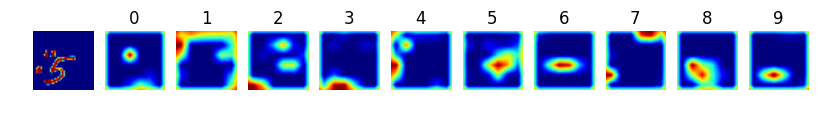

In [259]:
plot_fm_for_class(X_valid[12:13], resize_to=(40,40) )

-----

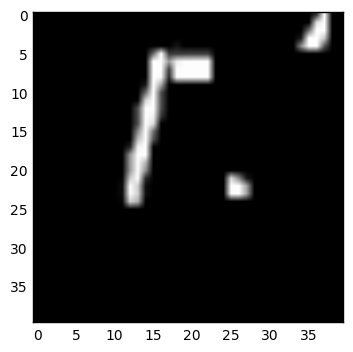

In [297]:
plt.imshow(X_train[90][0],cmap="gray")

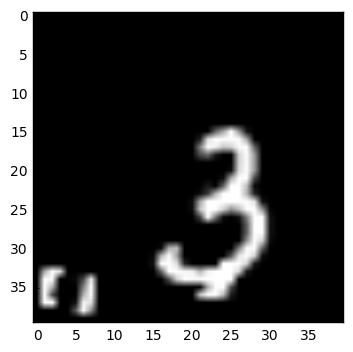

In [287]:
plt.imshow(X_train[10][0],cmap="gray")

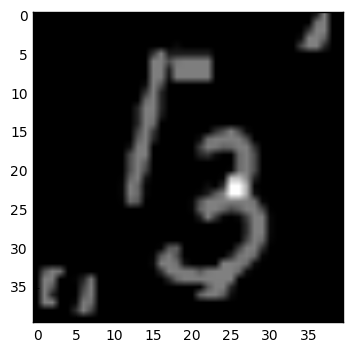

In [298]:
plt.imshow(X_train[90][0]+X_train[10][0],cmap="gray")

In [277]:
x_mix = (X_train[19][0]+X_train[0][0]).reshape((1,1,40,40))

predicted class: [8]


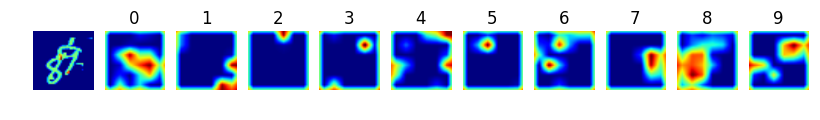

In [286]:
plot_fm_for_class(x_mix, resize_to=(40,40) )

In [299]:
x_mix2 = (X_train[90][0]+X_train[10][0]).reshape((1,1,40,40))

predicted class: [3]


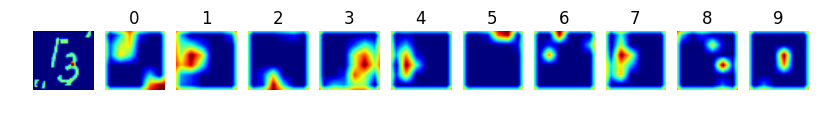

In [300]:
plot_fm_for_class(x_mix2, resize_to=(40,40) )